In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os.path as osp
from tqdm import tqdm_notebook as tqdm

In [2]:
feature_sparsity_thresh = 0.01
tfidf_sparsity_thresh = 0.05

In [3]:
data_dir = r"data\two-sigma-connect-rental-listing-inquiries"
with open(osp.join(data_dir, "train.json"), 'r') as f:
    j = json.load(f)

In [4]:
meta_df = pd.DataFrame()
for col in [col for col in j.keys() if col not in ["photos", "features"]]:
    s = pd.Series(j[col])
    meta_df[col] = s

In [5]:
meta_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,latitude,listing_id,longitude,manager_id,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,3495,405 East 56th Street,medium


In [6]:
n_rows = len(j["bathrooms"])

In [7]:
def preprocess_feature_name(feature_name):
    feat = re.sub(r"[^\w]", "", feature_name).lower()
    feat = ("hardwood" if "hardwood" in feat
            else "laundry" if "laundry" in feat
            else "pool" if "pool" in feat
            else "dryer" if "dryer" in feat
            else "washer" if "washer" in feat
            else "pool" if "pool" in feat
            else "garage" if "garage" in feat
            else "park" if "park" in feat
            else "outdoor" if "outdoor" in feat
            else "fitness" if "fitness" in feat
            else "fitness" if "gym" in feat
            else "liveinsuper" if "liveinsuper" in feat
            else "garden" if "garden" in feat
            else feat)
    return feat


In [8]:
features = np.hstack(list(j["features"].values()))
features = [preprocess_feature_name(feat) for feat in features]
features = pd.Series(features)

In [9]:
val_counts = features.value_counts()
val_counts = val_counts.loc[(val_counts / float(n_rows)) >= feature_sparsity_thresh]
val_counts

laundry              29759
elevator             26273
hardwood             24629
catsallowed          23540
dogsallowed          22035
washer               21014
doorman              20967
nofee                18085
fitness              13478
prewar               10501
outdoor               7675
roofdeck              7010
diningroom            5150
highspeedinternet     4315
pool                  3126
balcony               3058
newconstruction       2608
terrace               2313
exclusive             2167
garden                2132
loft                  2101
wheelchairaccess      1358
garage                1038
fireplace              921
simplex                908
lowrise                790
park                   707
reducedfee             699
furnished              690
multilevel             635
highceilings           614
liveinsuper            574
dtype: int64

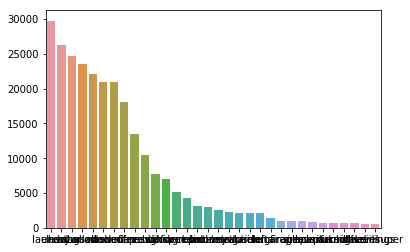

In [10]:
sns.barplot(val_counts.index, val_counts.values)

In [11]:
feature_names = val_counts.index
feat_rows = []
for feats in tqdm(j["features"].values()):
    _feats = [preprocess_feature_name(x) for x in feats]
    _feats = [x for x in _feats if x in feature_names]
    
    s = pd.Series(index=feature_names)
    s.loc[_feats] = 1
    feat_rows.append(s.tolist())

In [43]:
feat_df = pd.DataFrame(index=list(j["features"].keys()),
                       columns=["feat_" + f for f in feature_names],
                       data=feat_rows)
feat_df.fillna(0, inplace=True)
feat_df = feat_df.astype(int)
feat_df.head()

,feat_laundry,feat_elevator,feat_hardwood,feat_catsallowed,feat_dogsallowed,feat_washer,feat_doorman,feat_nofee,feat_fitness,feat_prewar,...,feat_garage,feat_fireplace,feat_simplex,feat_lowrise,feat_park,feat_reducedfee,feat_furnished,feat_multilevel,feat_highceilings,feat_liveinsuper
4,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words="english")
tfidf = vec.fit_transform(meta_df["description"].values)

In [45]:
tfidf_sparsity = np.ravel((tfidf != 0).mean(axis=0))
pd.Series(tfidf_sparsity).describe()

count    37529.000000
mean         0.001432
std          0.013731
min          0.000020
25%          0.000020
50%          0.000041
75%          0.000162
max          0.661878
dtype: float64

In [46]:
vocab = np.array(pd.Series(vec.vocabulary_).sort_values().index)
br_ind = vocab.tolist().index("br")

keep = np.nonzero(tfidf_sparsity >= tfidf_sparsity_thresh)[0].tolist()
if br_ind in keep:
    keep.remove(br_ind)

vocab = vocab[keep]
tfidf = tfidf[:, keep]

In [47]:
tdidf_cols = ["tfidf_" + word for word in vocab]
tfidf_df = pd.DataFrame(columns=tdidf_cols, data=tfidf.toarray(), index=meta_df.index)
tfidf_df.head(5)

,tfidf_24,tfidf_access,tfidf_amazing,tfidf_amenities,tfidf_apartment,tfidf_apartments,tfidf_appliances,tfidf_appointment,tfidf_area,tfidf_art,...,tfidf_walk,tfidf_war,tfidf_washer,tfidf_water,tfidf_website_redacted,tfidf_west,tfidf_white,tfidf_windows,tfidf_wood,tfidf_york
4,0.000000,0.0,0.0,0.0,0.044129,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.100381,0.039226,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.0,0.0,0.068603,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.030490,0.0,0.0,0.0,0.0,0.0
9,0.075823,0.0,0.0,0.0,0.230397,0.000000,0.053346,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.040960,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.0,0.0,0.0,0.043260,0.082142,0.050082,0.0,0.070589,0.0,...,0.0,0.0,0.07619,0.000000,0.038453,0.0,0.0,0.0,0.0,0.0
15,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.036095,0.0,0.0,0.0,0.0,0.0


In [48]:
(tfidf_df != 0).mean()

tfidf_24                  0.179081
tfidf_access              0.146134
tfidf_amazing             0.132720
tfidf_amenities           0.162992
tfidf_apartment           0.520526
tfidf_apartments          0.117807
tfidf_appliances          0.401078
tfidf_appointment         0.068629
tfidf_area                0.183194
tfidf_art                 0.079429
tfidf_available           0.146478
tfidf_ave                 0.051751
tfidf_avenue              0.052845
tfidf_away                0.105588
tfidf_bars                0.099976
tfidf_bath                0.145344
tfidf_bathroom            0.265258
tfidf_bathrooms           0.086785
tfidf_beautiful           0.191968
tfidf_bed                 0.099895
tfidf_bedroom             0.451329
tfidf_bedrooms            0.128830
tfidf_best                0.095133
tfidf_block               0.082043
tfidf_blocks              0.070879
tfidf_bond                0.109783
tfidf_brand               0.103481
tfidf_brick               0.071953
tfidf_bright        

In [49]:
df = pd.concat([meta_df, feat_df, tfidf_df], axis="columns")
df.to_csv(osp.join(data_dir, "sigma_train_feat_%.2f_tfidf_%.2f.csv" % (feature_sparsity_thresh, tfidf_sparsity_thresh)))